In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [2]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [5]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [6]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [7]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [8]:
ratings.movieId = ratings.movieId.map(movieid2idx)
ratings.userId = ratings.userId.map(userid2idx)

In [9]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [10]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [11]:
n_factors = 50

In [12]:
np.random.seed = 42

Randomly split into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [14]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [15]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [16]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [17]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [18]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [19]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [20]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/1
80000/80000 [==============================] - 75s - loss: 8.1394 - val_loss: 2.9278


In [24]:
model.optimizer.lr=0.01

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/3
80000/80000 [==============================] - 33s - loss: 2.8226 - val_loss: 1.9815
Epoch 2/3
80000/80000 [==============================] - 31s - loss: 2.3777 - val_loss: 1.6752
Epoch 3/3
80000/80000 [==============================] - 30s - loss: 2.2403 - val_loss: 1.5483


In [27]:
model.optimizer.lr=0.001

In [28]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/6
80000/80000 [==============================] - 30s - loss: 2.1870 - val_loss: 1.4991
Epoch 2/6
80000/80000 [==============================] - 30s - loss: 2.1576 - val_loss: 1.4753
Epoch 3/6
80000/80000 [==============================] - 30s - loss: 2.1334 - val_loss: 1.4602
Epoch 4/6
80000/80000 [==============================] - 29s - loss: 2.1105 - val_loss: 1.4627
Epoch 5/6
80000/80000 [==============================] - 31s - loss: 2.0893 - val_loss: 1.4561
Epoch 6/6
80000/80000 [==============================] - 30s - loss: 2.0654 - val_loss: 1.4527


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [22]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [23]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [24]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [25]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [26]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [27]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/1
80000/80000 [==============================] - 24s - loss: 8.8365 - val_loss: 3.1824


In [36]:
model.optimizer.lr=0.01

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/6
80000/80000 [==============================] - 33s - loss: 2.5902 - val_loss: 1.6620
Epoch 2/6
80000/80000 [==============================] - 32s - loss: 2.0017 - val_loss: 1.3636
Epoch 3/6
80000/80000 [==============================] - 31s - loss: 1.8407 - val_loss: 1.2423
Epoch 4/6
80000/80000 [==============================] - 29s - loss: 1.7452 - val_loss: 1.1819
Epoch 5/6
80000/80000 [==============================] - 30s - loss: 1.6627 - val_loss: 1.1430
Epoch 6/6
80000/80000 [==============================] - 29s - loss: 1.5876 - val_loss: 1.1110


In [38]:
model.optimizer.lr=0.001

In [39]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/10
80000/80000 [==============================] - 33s - loss: 1.5141 - val_loss: 1.0779
Epoch 2/10
80000/80000 [==============================] - 31s - loss: 1.4435 - val_loss: 1.0518
Epoch 3/10
80000/80000 [==============================] - 29s - loss: 1.3751 - val_loss: 1.0255
Epoch 4/10
80000/80000 [==============================] - 30s - loss: 1.3092 - val_loss: 1.0017
Epoch 5/10
80000/80000 [==============================] - 30s - loss: 1.2465 - val_loss: 0.9760
Epoch 6/10
80000/80000 [==============================] - 30s - loss: 1.1861 - val_loss: 0.9603
Epoch 7/10
80000/80000 [==============================] - 31s - loss: 1.1286 - val_loss: 0.9384s: 1.
Epoch 8/10
80000/80000 [==============================] - 29s - loss: 1.0747 - val_loss: 0.9206
Epoch 9/10
80000/80000 [==============================] - 30s - loss: 1.0223 - val_loss: 0.9007
Epoch 10/10
80000/80000 [==============================] - 31s - loss: 0.9731 - v

In [40]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80000 samples, validate on 20004 samples
Epoch 1/5
80000/80000 [==============================] - 32s - loss: 0.9268 - val_loss: 0.8669
Epoch 2/5
80000/80000 [==============================] - 31s - loss: 0.8832 - val_loss: 0.8520
Epoch 3/5
80000/80000 [==============================] - 30s - loss: 0.8430 - val_loss: 0.8379
Epoch 4/5
80000/80000 [==============================] - 31s - loss: 0.8055 - val_loss: 0.8279
Epoch 5/5
80000/80000 [==============================] - 33s - loss: 0.7711 - val_loss: 0.8170


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [41]:
model.save_weights(model_path+'bias.h5')

In [28]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [29]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.2772]], dtype=float32)

In [30]:
ratings.loc[lambda df: df.userId == 3, :].head()

,userId,movieId,rating,timestamp
147,3,20,4.0,949810645
148,3,139,5.0,949919556
149,3,140,5.0,949810582
150,3,141,5.0,949919681
151,3,30,4.0,949811346


In [31]:
model.predict([np.array([3]), np.array([20])])

array([[ 4.1075]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [32]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [33]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [34]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.33081228, 'Battlefield Earth (2000)'),
 (-0.11042142, 'Super Mario Bros. (1993)'),
 (-0.040663678, 'Spice World (1997)'),
 (-0.034995962, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.028942386, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.0030481354, 'Jaws 3-D (1983)'),
 (0.011134093, 'Blade: Trinity (2004)'),
 (0.011355514, 'Police Academy 6: City Under Siege (1989)'),
 (0.0233131, 'Haunting, The (1999)'),
 (0.035110515, 'Batman & Robin (1997)'),
 (0.0399152, 'Blame It on Rio (1984)'),
 (0.042447504, 'Speed 2: Cruise Control (1997)'),
 (0.060083818, 'Little Nicky (2000)'),
 (0.067369521, 'Wild Wild West (1999)'),
 (0.068562523, 'Howard the Duck (1986)')]

In [35]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.5102677, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.4151917, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3983922, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3978883, 'Tom Jones (1963)'),
 (1.3282667, '3:10 to Yuma (2007)'),
 (1.3147011, 'Persuasion (1995)'),
 (1.2942874, 'Shawshank Redemption, The (1994)'),
 (1.2891761, 'Exotica (1994)'),
 (1.2802837, 'You Can Count on Me (2000)'),
 (1.2729989, 'Rush (2013)'),
 (1.2695799, 'Smoke (1995)'),
 (1.2695324, 'Argo (2012)'),
 (1.2672178, 'Ray (2004)'),
 (1.2645335, 'Captain America: The Winter Soldier (2014)'),
 (1.2622322, 'Harry Potter and the Half-Blood Prince (2009)')]

We can now do the same thing for the embeddings.

In [36]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [38]:
fac0 = movie_pca[0]

In [39]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [40]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.014039068893575002, 'Grease 2 (1982)'),
 (0.013090979855196383, 'Anaconda (1997)'),
 (0.0092023413927731744, 'Howard the Duck (1986)'),
 (0.0091621661401226472, 'Police Academy 6: City Under Siege (1989)'),
 (0.0090509840018937835, "You Don't Mess with the Zohan (2008)"),
 (0.0088671729259246108, '2012 (2009)'),
 (0.0087170379327198705, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.0079056760887977039, 'Police Academy 3: Back in Training (1986)'),
 (0.0077171130262498958, 'Battlefield Earth (2000)'),
 (0.0074292612491803156, 'Blade: Trinity (2004)')]

In [41]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.052812225853955903, 'Usual Suspects, The (1995)'),
 (-0.050078892384031161, 'American Beauty (1999)'),
 (-0.049668835822481917, 'Godfather: Part II, The (1974)'),
 (-0.048881371690728363, 'Shawshank Redemption, The (1994)'),
 (-0.048700742143236907, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.048552953034175374, 'Pulp Fiction (1994)'),
 (-0.048225105081980198, 'Fargo (1996)'),
 (-0.047828977550033638, 'Snatch (2000)'),
 (-0.047790517926732744, 'Silence of the Lambs, The (1991)'),
 (-0.047658857791869187,
  "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)")]

In [42]:
fac1 = movie_pca[1]

In [43]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [44]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.063371539659460283, 'Brokeback Mountain (2005)'),
 (0.059304587215417599, 'City Lights (1931)'),
 (0.057425577407226716, 'Annie Hall (1977)'),
 (0.056807139496519624, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.054992327852352779, 'Manhattan (1979)'),
 (0.053388294985313528, 'Apocalypse Now (1979)'),
 (0.051538763286171872,
  'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (0.049073022091537973, 'Clockwork Orange, A (1971)'),
 (0.048038868719697814, 'General, The (1926)'),
 (0.047331644048943446, 'Chinatown (1974)')]

In [45]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10640029905835825, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.097716940338882827, 'Armageddon (1998)'),
 (-0.079389730424340499, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (-0.077364780607785358, 'Star Trek: Generations (1994)'),
 (-0.073674715224476495, 'Outbreak (1995)'),
 (-0.072324232668823263, 'Speed (1994)'),
 (-0.070746648748035823, 'Casper (1995)'),
 (-0.070217493686154001, 'Braveheart (1995)'),
 (-0.070187152997564256, 'True Lies (1994)'),
 (-0.07001535357039998, 'Stargate (1994)')]

In [46]:
fac2 = movie_pca[2]

In [47]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.060602876827684095, 'Down by Law (1986)'),
 (0.056298421549935744, 'Rosencrantz and Guildenstern Are Dead (1990)'),
 (0.054393985824583962, 'Zoolander (2001)'),
 (0.053880327475957959, 'Sherlock Holmes (2009)'),
 (0.052538037714051092,
  'How the Grinch Stole Christmas (a.k.a. The Grinch) (2000)'),
 (0.051841597780501583, 'Boondock Saints, The (2000)'),
 (0.051654282755724736, 'Pineapple Express (2008)'),
 (0.051402670462547026, "Pirates of the Caribbean: Dead Man's Chest (2006)"),
 (0.051144693334459659, 'Romeo Must Die (2000)'),
 (0.051008253772594297, 'Lake Placid (1999)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.14602697650390567, 'Silence of the Lambs, The (1991)'),
 (-0.1144226987190677, 'Terminator 2: Judgment Day (1991)'),
 (-0.11068519013697983, 'Fargo (1996)'),
 (-0.11011024657049545, 'Jurassic Park (1993)'),
 (-0.10947914659916347, 'Lion King, The (1994)'),
 (-0.10727239796075787, 'Dances with Wolves (1990)'),
 (-0.093936711803275078, "Schindler's List (1993)"),
 (-0.085515206606793487, 'Rob Roy (1995)'),
 (-0.083172898067454204, 'Fugitive, The (1993)'),
 (-0.08176082587849294, 'Braveheart (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [50]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

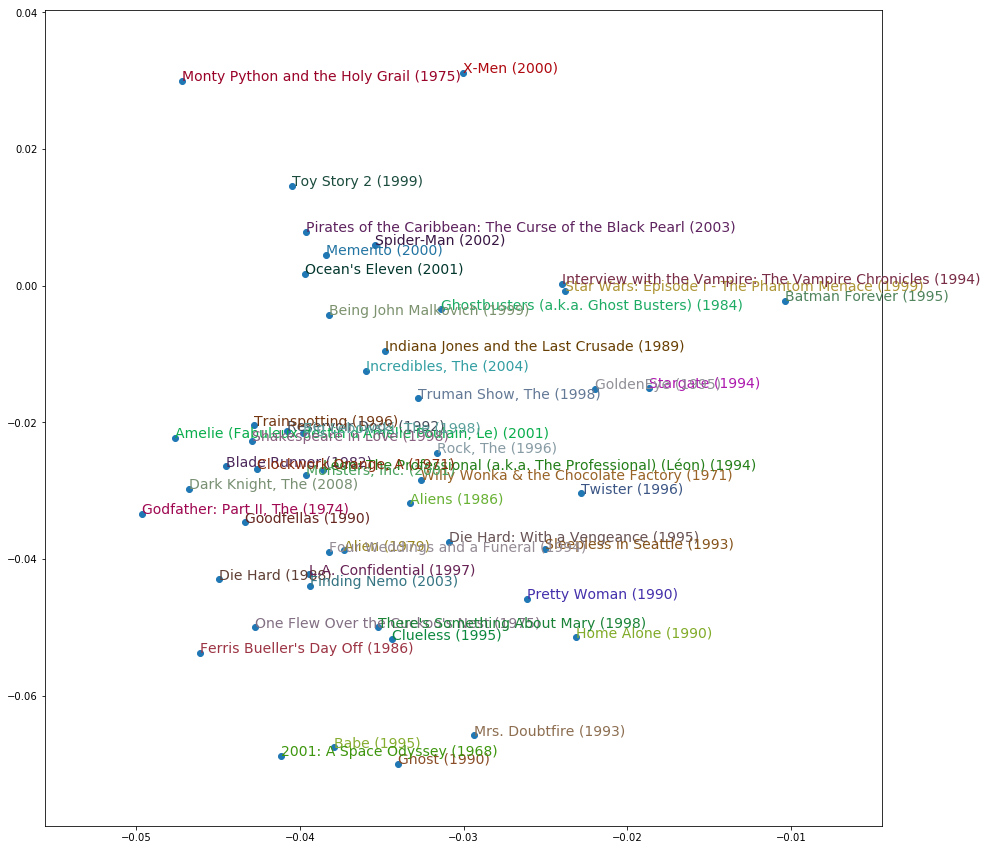

In [51]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [52]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [53]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [54]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [55]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79899 samples, validate on 20105 samples
Epoch 1/8
79899/79899 [==============================] - 28s - loss: 2.4295 - val_loss: 0.9207
Epoch 2/8
79899/79899 [==============================] - 45s - loss: 1.4696 - val_loss: 0.8448
Epoch 3/8
79899/79899 [==============================] - 36s - loss: 1.2279 - val_loss: 0.8303
Epoch 4/8
79899/79899 [==============================] - 36s - loss: 1.0340 - val_loss: 0.8173
Epoch 5/8
79899/79899 [==============================] - 37s - loss: 0.9087 - val_loss: 0.8089
Epoch 6/8
79899/79899 [==============================] - 36s - loss: 0.8407 - val_loss: 0.7976
Epoch 7/8
79899/79899 [==============================] - 39s - loss: 0.8164 - val_loss: 0.7938
Epoch 8/8
79899/79899 [==============================] - 37s - loss: 0.8045 - val_loss: 0.7936


In [93]:
nn.save_weights(model_path+'nn.h5')

In [94]:
nn.load_weights(model_path+'nn.h5')

This improves on our already impressive accuracy even further!